# Домашнее задание седьмого урока.

Ваш менее опытный коллега не уверен, что его таблица retail действительно создалась и добавилась в базу данных. Напишите запрос, который создаст таблицу, если она еще не существует (**IF NOT EXISTS**), со следующими параметрами:

Название: **retail**

База: **test**
Столбцы:

- InvoiceNo – идентификатор заказа, строковое значение

- StockCode – идентификатор товара, строковое значение

- Description – описание товара, строковое значение

- Quantity – количество единиц товара, добавленных в корзину (особенность данных – значения могут быть отрицательными, 32 бита)

- InvoiceDate – дата и время создания заказа (транзакции), часовой пояс – 'Europe/London'

- UnitPrice – цена за единицу товара (особенность данных – значения могут быть отрицательными, точность – три знака после точки, 64 бита)

- CustomerID – идентификатор пользователя, целое положительное число, 32 бита.

- Country – страна, строковое значение. 

Движок: **MergeTree**

Сортировка: **InvoiceDate, CustomerID**
```sql
CREATE TABLE IF NOT EXISTS test.retail 
    (
        InvoiceNo String,
        StockCode String,
        Description String,
        Quantity Int32,
        InvoiceDate DateTime('Europe/London'),
        UnitPrice Decimal64(3),
        CustomerID Uint32,
        Country String
    )
ENGINE = MergeTree
ORDER BY InvoiceDate, CustomerID
```
---------------------
В следующих шагах используется **default.retail** – данные о транзакциях британского интернет-магазина в период с 1 декабря 2010 по 9 декабря 2011, где:

* InvoiceNo – номер транзакции
* StockCode – код товара
* Description – описание товара
* Quantity – количество единиц товара, добавленных в заказ
* InvoiceDate – дата транзакции 
* UnitPrice – цена за единицу товара
* CustomerID – id клиента
* Country – страна, где проживает клиент

**2. Для начала посмотрите, в каких странах имеется наибольшее число уникальных пользователей. Постройте барчарт, где:**

* по оси x – страна
* по оси y – число пользователей

**В качестве ответа укажите число уникальных пользователей из Великобритании.** 

Note: запятые в Redash отделяют каждые три знака в числе (тысячные доли, миллионные и так далее). Например, 2,535,966 - это 2535966. В ответ надо писать число без запятых.
```sql
SELECT Country, uniqExact(CustomerID) as UniqCust
FROM default.retail
GROUP BY Country
ORDER BY UniqCust DESC
```

![Google Drive Image](https://drive.google.com/uc?export=view&id=1_TV-coJCAewyqIXI6MFC1K1PV-mGY-eN)

Ответ: `3950`


**3. Следующая задача – посмотреть на динамику изменения числа активных пользователей в месяц в Великобритании, Австралии и Нидерландах. Полученная вами результирующая таблица должна иметь вид: страна - число уникальных пользователей за определённый месяц.**

* MAU (monthly active users) – число уникальных пользователей за месяц. Активные пользователи – те, кто сделал хотя бы один заказ за выбранный промежуток времени (месяц).

**В качестве ответа укажите наименьшее число пользователей за февраль 2011.** 

```sql
SELECT Country, uniqExact(CustomerID) as UniqCust
FROM default.retail
WHERE Country IN ['United Kingdom','Australia','Netherlands']
    AND toStartOfMonth(InvoiceDate) = '2011-02-01' 
GROUP BY Country
```

* http://localhost:5000/embed/query/3/visualization/8?api_key=tUf84pyNzUuCRKZBEozSnpxmpuHaMAOSSjDrCLK4&
нерабочая ссылка тк
напрямую с redashа запущенного докером ссылка на хост, 
поэтому заливаю на гугл диск

![Google Drive Image](https://drive.google.com/uc?export=view&id=1JenbKidS4rd7wHI0XLH0PR1FL8KCj37q)


Ответ: `2`

**4. Как вы могли заметить, график с предыдущего шага получается не очень информативным для 2 из 3 стран. Давайте посмотрим на динамику изменения числа активных пользователей в месяц уже для всех стран, кроме Великобритании.**

**В каких месяцах число активных пользователей во Франции было больше, чем в Германии?**
```sql
SELECT Country, 
    toStartOfMonth(InvoiceDate) as month,
    uniqExact(CustomerID) as UniqCust
FROM default.retail
WHERE Country!='United Kingdom' 
AND Country IN ('France', 'Germany')
GROUP BY Country, month
ORDER BY Country, month
```

![Google Drive Image](https://drive.google.com/uc?export=view&id=1j4AsN3KswGyDYJZawosOo5I3kI1W1FEZ)


* **Май 2011**
* Всегда
* Июнь 2011
* **Сентябрь 2011**
* **Декабрь 2011**
* Декабрь 2010

**5. Теперь проанализируем сами заказы. Посчитайте среднюю сумму заказа (AOV – average order value) в каждой из стран.**

**Обратите внимание, что пользователь может добавить несколько одинаковых товаров в один заказ, и для подсчета суммы каждого заказа можно создать столбец TotalPrice, в котором будет храниться цена, которую пользователь заплатил, например, за три упаковки чая.**


InvoiceNo |	Description|Quantity |	UnitPrice	|TotalPrice
---------:|------------|--------:|------------:|:-------:
12345     |	     12345 |	    3|	       1.2 |	3.6 
12345     |	COOKIES    |	 1	 |         2.5 | 	2.5


**Далее для каждого заказа нужно просуммировать полученную колонку, а затем сгруппировать данные по странам и посчитать среднюю сумму заказа в каждой из них.**

**Визуализируйте результат. Из представленных вариантов ответа выберите страны, входящие в топ-3 по величине средней суммы заказа.**

NB! В таблице есть отрицательные значения Quantity, что соответствует отмененным заказам. Их в расчет AOV включать не нужно. 

```sql
SELECT Country, 
    AVG(TotalPrice) AS avgTotalPrice
FROM (SELECT Country,
        SUM(Quantity*UnitPrice) as TotalPrice
    FROM default.retail
    WHERE Quantity >= 0
    GROUP BY Country, InvoiceNo)
GROUP BY Country
ORDER BY avgTotalPrice DESC
```

![Google Drive Image](https://drive.google.com/uc?export=view&id=1MwJKhESVZaDsyM82x3C1E88vYev5G0Un)

* **Netherlands**
* **Australia**
* **Singapore**
* Sweden
* Japan
* United Kingdom


**6. Как изменялась средняя сумма заказа в разных странах по месяцам?**

**Предположим, нас интересует динамика в следующих странах: United Kingdom, Germany, France, Spain, Netherlands, Belgium, Switzerland, Portugal, Australia, USA. Визуализируйте результат и выберите верные утверждения.**

```sql
SELECT Country, 
    month,
    AVG(TotalPrice) AS avgTotalPrice
FROM (SELECT toStartOfMonth(InvoiceDate) as month,
        Country,
        SUM(Quantity*UnitPrice) as TotalPrice
    FROM default.retail
    WHERE Quantity >= 0 
    AND Country IN ['United Kingdom', 'Germany', 'France', 'Spain', 'Netherlands', 'Belgium', 'Switzerland', 'Portugal', 'Australia', 'USA']
    GROUP BY Country, month, InvoiceNo)
GROUP BY Country, month
ORDER BY Country, month
```

![Google Drive Image](https://drive.google.com/uc?export=view&id=1hofsH8r8xIUHOOs80sCAuTrdsLZ92CIU)

* Аномальный рост среднего чека произошел в июле 2011 среди пользователей из Австралии
* **Аномальный рост среднего чека произошел в августе 2011 среди пользователей из Австралии**
* **Самые большие значения среднего чека наблюдаются в Австралии и Нидерландах.**
* Второй по размеру средний чек – в Германии
* **Примерно до октября средний чек США постепенно рос**
* Средний чек в Великобритании значительно выше, чем во всех других странах

**7. Сколько товаров пользователи обычно добавляют в корзину? Посчитайте среднее количество товаров, добавленных в корзину, с разбивкой по странам.**

**В качестве ответа укажите среднее число товаров в заказе среди пользователей в Канаде (Canada). Разделитель - точка.**

```sql
SELECT Country, 
    AVG(Amount) AS avgAmount
FROM (SELECT InvoiceNo,
        Country,
        SUM(Quantity) as Amount
    FROM default.retail
    WHERE Quantity >= 0 
    GROUP BY Country, InvoiceNo)
GROUP BY Country
ORDER BY avgAmount DESC
```

![Google Drive Image](https://drive.google.com/uc?export=view&id=1WMlALlyuG3OV625IhonTLFQS05qomU6s)

Ответ: `460.50`


**8. Возможно, результат на предыдущем шаге показался вам странным, особенно если соотнести средний размер корзины с числом уникальных пользователей в некоторых странах.** 

**Посмотрим на Нидерланды (Netherlands) более подробно. Сгруппируйте данные по пользователям и посмотрите, кто купил наибольшее число товаров. В ответе укажите идентификатор данного пользователя.**

```sql
SELECT CustomerID,
        SUM(Quantity) as Amount
    FROM default.retail
    WHERE Quantity >= 0
    AND Country = 'Netherlands'
    GROUP BY Country, CustomerID
    ORDER BY Amount DESC
```

![Google Drive Image](https://drive.google.com/uc?export=view&id=1447kRmhU02RIzvhw7EtVfUXBg07V6tsH)

Ответ: `14646`

**9. Один из пользователей добавил к себе в корзину почти 200 тысяч товаров. Не кажется ли это подозрительным? Изучите, что именно он покупает, посмотрите на количество товаров в каждом заказе, итоговые суммы. Подумайте, кто или что это может быть 🤔**

**Когда подумаете, просто введите идентификатор данного пользователя еще раз в поле ниже.**



Ответ: `14646`

ищем ошибку в данных у 14646-ого клиента

In [92]:
query = """
SELECT StockCode, SUM(Quantity) as Quan, Description, toFloat64(UnitPrice)
    FROM default.retail
    WHERE Quantity >= 0
    AND CustomerID = 14646
    AND Country = 'Netherlands'
    GROUP BY StockCode, Description, toFloat64(UnitPrice)
    ORDER BY Quan DESC
"""

df = ph.read_clickhouse(query, connection=connection)
df

,StockCode,Quan,Description,toFloat64(UnitPrice)
0,22629,4480,SPACEBOY LUNCH BOX,1.65
1,22630,4096,DOLLY GIRL LUNCH BOX,1.65
2,21212,4080,PACK OF 72 RETROSPOT CAKE CASES,0.42
3,23084,3361,RABBIT NIGHT LIGHT,2.08
4,22326,3120,ROUND SNACK BOXES SET OF4 WOODLAND,2.55
...,...,...,...,...
913,23473,1,WOODLAND SMALL RED FELT HEART,0.83
914,23510,1,MINI PLAYING CARDS GYMKHANA,0.42
915,22728,1,ALARM CLOCK BAKELIKE PINK,3.75
916,21981,1,PACK OF 12 WOODLAND TISSUES,0.39


в количестве не видно явной ошибки, товары бывают в разных количествах, 
товары разнообразные

In [103]:
query = """
SELECT StockCode, SUM(Quantity) as Quan, Description, toFloat64(UnitPrice) as p
    FROM default.retail
    WHERE Quantity >= 0
    AND CustomerID = 14646
    AND Country = 'Netherlands'
    GROUP BY StockCode, Description, toFloat64(UnitPrice)
    ORDER BY p
"""

df = ph.read_clickhouse(query, connection=connection)
df

,StockCode,Quan,Description,p
0,23268,192,SET OF 2 CERAMIC CHRISTMAS REINDEER,0.00
1,23270,96,SET OF 2 CERAMIC PAINTED HEARTS,0.00
2,21786,144,POLKADOT RAIN HAT,0.00
3,22955,144,36 FOIL STAR CAKE CASES,0.00
4,22343,96,PARTY PIZZA DISH RED RETROSPOT,0.19
...,...,...,...,...
913,POST,1,POSTAGE,18.00
914,23064,4,CINDERELLA CHANDELIER,41.75
915,22929,4,SCHOOL DESK AND CHAIR,57.95
916,22826,2,LOVE SEAT ANTIQUE WHITE METAL,85.00


есть бесплатные товары, но их немного, чтобы повлиять на что то
<br>если построить зависимость количества от цены, то оно будет с обр наклоном
что вполне себе реалистично

<Axes: xlabel='Quan', ylabel='p'>

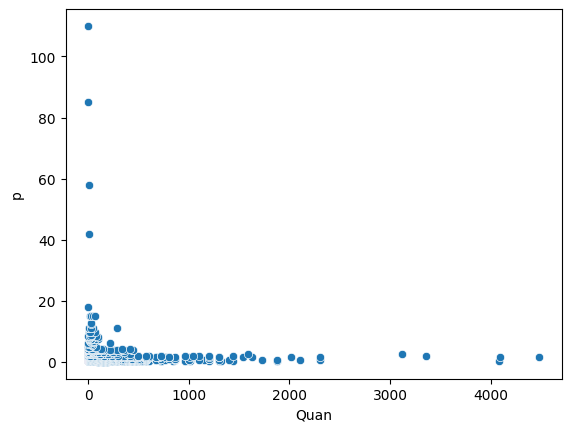

In [105]:
sns.scatterplot(x=df.Quan, y=df.p)

не линейно, но вполне реалистично

In [39]:
query = """
SELECT uniqExact(StockCode)
    FROM default.retail
    WHERE Country = 'Netherlands'
"""

df = ph.read_clickhouse(query, connection=connection)
df

,uniqExact(StockCode)
0,785


большинство уникальных товаров в нидерландах куплено по этому айди

In [42]:
query = """
SELECT CustomerID, Quantity
    FROM default.retail
    WHERE Country = 'Netherlands'
    AND StockCode = '23084'
"""

df = ph.read_clickhouse(query, connection=connection)
df

,CustomerID,Quantity
0,14646,480
1,14646,2400
2,14646,216
3,14646,24
4,14646,240
5,14646,1
6,14646,1440


самый покупаемый товар есть в нескольких заказах 
в различных количествах
никакой закономерности не видно

In [109]:
query = """
SELECT InvoiceNo, COUNT(DISTINCT StockCode)as c, SUM(Quantity) as s,
SUM(Quantity*toFloat64(UnitPrice)) as Money, toString(InvoiceDate) as D 
    FROM default.retail
    WHERE Country = 'Netherlands'
    AND CustomerID = 14646
   AND Quantity >= 0
    GROUP BY InvoiceNo, D
    ORDER BY Money DESC
"""

df = ph.read_clickhouse(query, connection=connection)
df

,InvoiceNo,c,s,Money,D
0,572035,125,13392,20277.92,2011-10-20 12:03:00
1,563076,119,14730,19150.66,2011-08-11 16:12:00
2,548011,89,11116,15719.56,2011-03-29 11:14:00
3,552883,92,12266,14415.74,2011-05-12 10:13:00
4,562789,96,7807,12341.21,2011-08-09 13:50:00
...,...,...,...,...,...
69,569735,1,2,30.00,2011-10-06 10:34:00
70,560710,10,10,26.02,2011-07-20 12:51:00
71,569720,15,15,23.39,2011-10-06 09:11:00
72,565975,1,1,2.08,2011-09-08 11:28:00


заказ на 0 денег наверное из бесплатных товаров
<br>думаю если построить график кореляции кол-ва товаров и 
<br>цены то там будет взаимосвязь
<br>может есть какие-то выбросы, но не думаю что они меняют общую картину
<br>множества разнообразных по масштабу заказов

In [89]:
query = """
SELECT InvoiceNo, StockCode, Quantity, toFloat64(UnitPrice), Description
    FROM default.retail
    WHERE Country = 'Netherlands'
    AND CustomerID = 14646
    AND InvoiceNo = '564651'
    ORDER BY Quantity
"""

df = ph.read_clickhouse(query, connection=connection)
df

,InvoiceNo,StockCode,Quantity,toFloat64(UnitPrice),Description
0,564651,23270,96,0.0,SET OF 2 CERAMIC PAINTED HEARTS
1,564651,22955,144,0.0,36 FOIL STAR CAKE CASES
2,564651,21786,144,0.0,POLKADOT RAIN HAT
3,564651,23268,192,0.0,SET OF 2 CERAMIC CHRISTMAS REINDEER


<Axes: xlabel='s', ylabel='Money'>

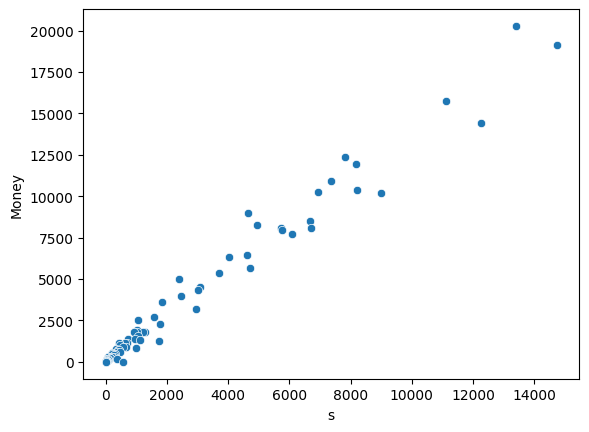

In [102]:
sns.scatterplot(x=df.s, y=df.Money)

In [84]:
query = """
SELECT InvoiceNo, COUNT(DISTINCT StockCode)as c, SUM(Quantity) as s,
SUM(Quantity*toFloat64(UnitPrice)) as Money
    FROM default.retail
    WHERE Country = 'Netherlands'
    AND CustomerID = 14646
   AND Quantity < 0
    GROUP BY InvoiceNo
    ORDER BY Money DESC
"""

df = ph.read_clickhouse(query, connection=connection)
df

,InvoiceNo,c,s,Money
0,C543388,1,-3,-45.0
1,C563593,1,-1,-206.4
2,C564899,3,-768,-465.6


отмененных всего лишь 3 из 77+3

In [90]:
query = """
SELECT InvoiceNo, StockCode, Quantity, toFloat64(UnitPrice), Description
    FROM default.retail
    WHERE Country = 'Netherlands'
    AND CustomerID = 14646
    AND InvoiceNo = '572035'
    ORDER BY Quantity
"""

df = ph.read_clickhouse(query, connection=connection)
df

,InvoiceNo,StockCode,Quantity,toFloat64(UnitPrice),Description
0,572035,22636,8,7.65,CHILDS BREAKFAST SET CIRCUS PARADE
1,572035,22846,8,14.95,BREAD BIN DINER STYLE RED
2,572035,22487,12,8.50,WHITE WOOD GARDEN PLANT LADDER
3,572035,22847,12,14.95,BREAD BIN DINER STYLE IVORY
4,572035,21630,12,7.95,FLOOR CUSHION ELEPHANT CARNIVAL
...,...,...,...,...,...
120,572035,23310,360,0.36,BUBBLEGUM RING ASSORTED
121,572035,84991,360,0.42,60 TEATIME FAIRY CAKE CASES
122,572035,23345,400,1.08,DOLLY GIRL BEAKER
123,572035,23077,400,1.04,DOUGHNUT LIP GLOSS


самый большой заказ, ничего подозрительного

остается посмотреть, что с датами

In [111]:
query = """
SELECT InvoiceNo, COUNT(DISTINCT StockCode)as c, SUM(Quantity) as s,
SUM(Quantity*toFloat64(UnitPrice)) as Money, toString(InvoiceDate) as D 
    FROM default.retail
    WHERE Country = 'Netherlands'
    AND CustomerID = 14646
   AND Quantity >= 0
    GROUP BY InvoiceNo, D
    ORDER BY D DESC
"""

df = ph.read_clickhouse(query, connection=connection)
df

,InvoiceNo,c,s,Money,D
0,581338,1,140,250.60,2011-12-08 12:12:00
1,581176,8,452,575.88,2011-12-07 15:19:00
2,581175,77,7366,10901.54,2011-12-07 15:16:00
3,578143,11,1284,1835.96,2011-11-23 11:06:00
4,578141,1,200,290.00,2011-11-23 11:04:00
...,...,...,...,...,...
69,541608,2,288,305.28,2011-01-20 09:54:00
70,541570,33,6072,7722.04,2011-01-19 12:34:00
71,541206,79,8210,10389.06,2011-01-14 12:24:00
72,539731,54,6668,8520.92,2010-12-21 15:05:00


<Axes: ylabel='D'>

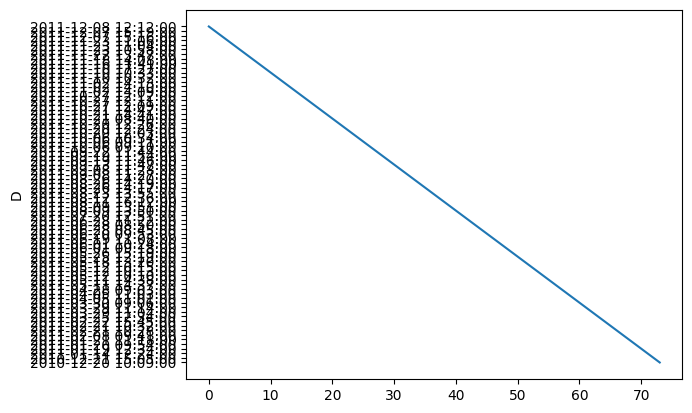

In [113]:
sns.lineplot(df.D)

c датами вновь все окей, заказы регулярны на протяжении года

**Вывод:**

в данных закономерность указывающую на ошибку в данных не вижу,
думаю в недерландах какой-то сайт перепродает товары